In [15]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from tqdm import tqdm
from google.colab import drive

In [16]:
# Mount Google Drive
drive.mount('/content/drive')
# Change to the ICBHI2024 directory on my Google Drive
os.chdir('/content/drive/MyDrive/ICBHI2024')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading data from data/Train...


100%|██████████| 16/16 [00:02<00:00,  5.78it/s]


Loading data from data/Test...


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


Epoch 1/100
9/9 [==============================] - 1s 28ms/step - loss: 6.0083 - accuracy: 0.3299 - val_loss: 2.6134 - val_accuracy: 0.3854
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 1.4449 - accuracy: 0.4184 - val_loss: 1.0931 - val_accuracy: 0.3472
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 1.0460 - accuracy: 0.4427 - val_loss: 1.0282 - val_accuracy: 0.4410
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.9831 - accuracy: 0.5425 - val_loss: 0.9729 - val_accuracy: 0.5521
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 0.9191 - accuracy: 0.5894 - val_loss: 0.9134 - val_accuracy: 0.6111
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 0.8264 - accuracy: 0.6649 - val_loss: 0.8393 - val_accuracy: 0.6597
Epoch 7/100
9/9 [==============================] - 0s 7ms/step - loss: 0.7335 - accuracy: 0.7118 - val_loss: 0.7555 - val_accuracy: 0.6979
Epoch 8/100
9/9 [=========

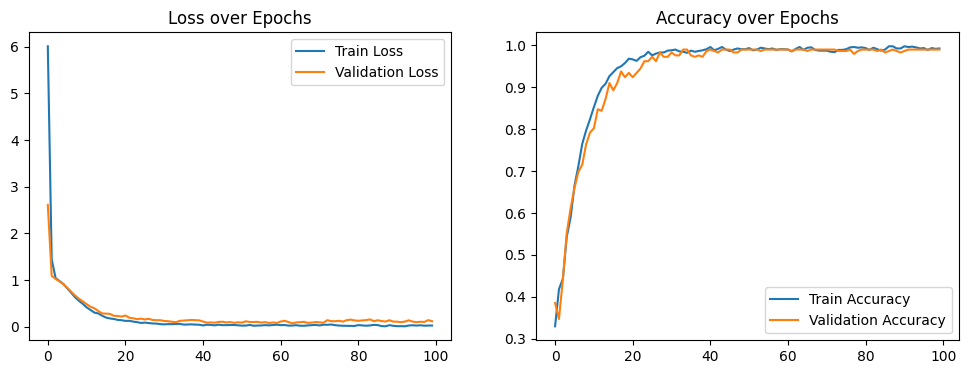

In [64]:
import numpy as np
import os
import random
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Augmentation functions
def add_noise(data, noise_factor=0.1):
    noise = np.random.randn(*data.shape) * noise_factor
    return data + noise

def scale_data(data, scale_factor=1.2):
    return data * scale_factor

# Function to load data from npz files
def load_npz_data(fpath):
    all_data = np.load(fpath)
    return all_data['data']

# Function to load brain region names from a file
def load_brain_regions(atlas_path):
    brain_regions = {}
    with open(atlas_path, 'r') as file:
        lines = file.readlines()[1:]  # Skip the header line
        for line in lines:
            index, region = line.strip().split('\t')
            brain_regions[int(index)] = region
    return brain_regions

# Function to slice fMRI data into baseline, video, and rating segments
def slice_fMRI_data(data):
    baseline = data[:, 0:5]  # First 5 seconds as baseline
    video = data[:, 5:20]    # 15 seconds of the video
    rating = data[:, 20:25]  # Last 5 seconds for rating
    return baseline, video, rating

# Function to extract features from fMRI data
def extract_fmri_features(fmri_data, brain_regions):
    features = []
    for trial in range(fmri_data.shape[0]):  # Iterate through each trial
        _, video_data, _ = slice_fMRI_data(fmri_data[trial])

        trial_features = []
        for region in range(len(brain_regions)):  # Iterate through each region
            var_video = np.var(video_data[region])

            region_features = [
                region,  # Region number
                var_video
            ]
            trial_features.extend(region_features)
        features.append(trial_features)
    return np.array(features)

# Function to augment data
def augment_data(data, labels):
    augmented_data = []
    augmented_labels = []
    for sample, label in zip(data, labels):
        augmented_data.append(sample)
        augmented_labels.append(label)

        augmented_data.append(add_noise(sample))
        augmented_labels.append(label)

        augmented_data.append(scale_data(sample))
        augmented_labels.append(label)

    return np.array(augmented_data), np.array(augmented_labels)

# Function to load participant data
def load_participants_data(data_dir, brain_regions, augment_data_flag=False, labels_present=True):
    subjects = sorted([s for s in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, s))])
    all_fmri_features = []
    all_labels = []
    subject_names = []

    print(f"Loading data from {data_dir}...")
    for subject in tqdm(subjects):
        if subject.startswith('.'):
            continue  # skip hidden files like .DS_Store

        subject_path = os.path.join(data_dir, subject)
        fMRI_data_path = os.path.join(subject_path, 'fMRI_data.npz')
        labels_path = os.path.join(subject_path, 'labels.npz')

        if os.path.exists(fMRI_data_path):
            fMRI_data = load_npz_data(fMRI_data_path)

            # Extract features for each trial of the subject
            fmri_features = extract_fmri_features(fMRI_data, brain_regions)
            all_fmri_features.append(fmri_features)
        else:
            print(f"Missing data for {subject}")

        if labels_present and os.path.exists(labels_path):
            labels = load_npz_data(labels_path)[:, 0]  # Only take the class label
            all_labels.append(labels)
        elif labels_present:
            print(f"Missing labels for {subject}")

        # Track the subject names
        subject_names.append(subject)

    # Combine all features and labels from all subjects
    all_fmri_features = np.concatenate(all_fmri_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0) if labels_present and all_labels else None

    if augment_data_flag and all_labels is not None:
        all_fmri_features, all_labels = augment_data(all_fmri_features, all_labels)

    if labels_present and all_labels is not None:
        return {'fmri_features': all_fmri_features, 'labels': all_labels, 'subject_names': subject_names}
    else:
        return {'fmri_features': all_fmri_features, 'subject_names': subject_names}

# Example usage:
atlas_path = 'data/Supplementary/BN_atlas.txt'
train_data_dir = 'data/Train'
test_data_dir = 'data/Test'

brain_regions = load_brain_regions(atlas_path)
train_data = load_participants_data(train_data_dir, brain_regions, augment_data_flag=True, labels_present=True)
test_data = load_participants_data(test_data_dir, brain_regions, labels_present=False)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data['fmri_features'])
X_test = scaler.transform(test_data['fmri_features'])

# Prepare the labels
num_classes = 3
y_train = to_categorical(train_data['labels'], num_classes)

# Reshape data for input into Conv1D (add channel dimension)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.35)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Create and compile the model
input_shape = (X_train.shape[1], 1)
model = create_cnn_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.006),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_val, y_val))

# Making predictions on the test data without labels
predictions = model.predict(X_test)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted classes
print("Predicted Classes:", predicted_classes)


# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


In [65]:
# Print the final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy}")
print(f"Final Validation Accuracy: {val_accuracy}")

Final Training Accuracy: 0.9921875
Final Validation Accuracy: 0.9895833134651184
